# 神经网络反向传播 


In [115]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio
import matplotlib
import scipy.optimize as opt

In [116]:
def load_data(path, transpose=True):
    data = sio.loadmat(path)
    X = data['X']
    y = data['y']
    if transpose :
        Z = []
        for row in X :
            Z.append(row.reshape((20,20)).T)
        X = []
        for row in Z :
            X.append(row.reshape(400))
        X = np.array(X)
    return X, y

In [117]:
X, _ = load_data('ex4data1.mat')
X.shape

(5000, 400)

## 查看数据集（10*10的图像）

In [118]:
def plot_100_image(X):
        sample_idx = np.random.choice(np.arange(0,5000,1),100)
        print( type(sample_idx) )
     #   print(sample_idx)
        sample_data = X[sample_idx,:]

        fig,ax = plt.subplots(10,10,figsize = (8,8))
        for r in range(10):
                for c in range(10):
                        ax[r,c].matshow(sample_data[10*r+c].reshape(20,20),cmap = matplotlib.cm.binary )
        #这两行代码意图是移除坐标轴上的刻度数字，让图像看起来更干净。
                        ax[r,c].set_xticks([])
                        ax[r,c].set_yticks([])
        plt.show()


- ax_array[r, c]: 获取当前第 r 行第 c 列的子图对象。

- sample_images[10 * r + c]: 取出第 10*r + c 个样本（将 2D 网格坐标转换为 1D 数组索引）。

- reshape((size, size)): 将展平的一维像素数组（例如 400）重新变成二维图像矩阵（例如 20x20），以便绘图。

- matshow(...): 将矩阵显示为图像。

- cmap=matplotlib.cm.binary: 设置颜色映射为二值颜色（通常是黑白灰度），适合显示黑白图像。

<class 'numpy.ndarray'>


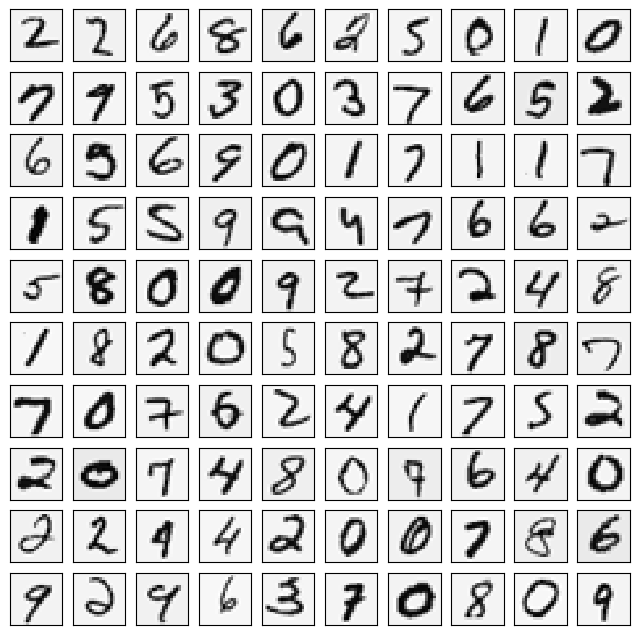

In [119]:
plot_100_image(X)
plt.show()

In [120]:
X_raw, y_raw = load_data('ex4data1.mat', transpose=False)
# 增加全部为1的一列，
X = np.insert(X_raw, 0, np.ones(X_raw.shape[0]), axis=1)
X.shape

(5000, 401)

In [121]:
y_raw.shape

(5000, 1)

# 扩展函数

In [122]:
def expand_y(y):
    res = []
    for i in range(y.shape[0]):
        a = np.zeros(10)
        a[y[i][0]-1] = 1
        res.append(a)
    return np.array(res)
#     """expand 5000*1 into 5000*10
#     where y=10 -> [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]: ndarray
#     """

In [123]:
y = expand_y(y_raw)
y

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], shape=(5000, 10))

# 读取权重

In [124]:
def load_weight(path):
    data = sio.loadmat(path)
    return data['Theta1'], data['Theta2']

In [125]:
t1, t2 = load_weight('ex4weights.mat')
t1.shape, t2.shape

((25, 401), (10, 26))

序列化2矩阵
在这个nn架构中，我们有theta1（25,401），theta2（10,26），它们的梯度是delta1，delta2  

In [126]:
def serialize(a, b):
    return np.concatenate( [ np.ravel(a), np.ravel(b) ])

np.ravel 一句话概括：它的作用是将多维数组（矩阵）“拍扁”成一维数组。

这是 np.ravel() 和另一个类似函数 numpy数组.flatten() 最大的区别，也是最需要注意的地方。(在numpy数组情况下)
- np.ravel() 返回的是视图 (View)：这意味着它不复制数据，只是换了一种方式看原来的数据。如果你修改了 ravel 返回的数组，原数组也会跟着变！
- flatten() 返回的是副本 (Copy)：它会把数据复制一份。修改新数组，原数组不会变。

In [127]:
theta = serialize(t1, t2)  # 扁平化参数，25*401+10*26=10285
theta.shape

(10285,)

# 前向传播 Feedforward
> (400 + 1) -> (25 + 1) -> (10)

<img style="float: center;" src="./img/nn_model.png">

In [128]:
def feed_forward(theta, X):
  
    t1, t2 = deserialize(theta)  # t1: (25,401) t2: (10,26)
    m = X.shape[0]
    a1 = X  # 5000 * 401

    z2 = a1 @ t1.T  # 5000 * 25
    a2 = np.insert(sigmoid(z2), 0, np.ones(m), axis=1)  # 5000*26

    z3 = a2 @ t2.T  # 5000 * 10
    h = sigmoid(z3)  # 5000*10, this is h_theta(X)

    # return的这些均是后向传播所需要的
    return a1, z2, a2, z3, h
    # a1就是原始数据
    # z2就是乘以权重后的数据
    # a2就是在z2的基础上加上一个1
    # z3就是乘上最后的权重
    # h是概率

Sigmoid函数的定义为：
$$g(z)={\frac{1}{1+e^{{-z}}}}$$

In [129]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [130]:
def deserialize(seq):
#     """into ndarray of (25, 401), (10, 26)"""
    return seq[:25 * 401].reshape(25, 401), seq[25 * 401:].reshape(10, 26)

In [131]:
_, _, _, _, h = feed_forward(theta, X)
h # 5000*10

array([[1.12661530e-04, 1.74127856e-03, 2.52696959e-03, ...,
        4.01468105e-04, 6.48072305e-03, 9.95734012e-01],
       [4.79026796e-04, 2.41495958e-03, 3.44755685e-03, ...,
        2.39107046e-03, 1.97025086e-03, 9.95696931e-01],
       [8.85702310e-05, 3.24266731e-03, 2.55419797e-02, ...,
        6.22892325e-02, 5.49803551e-03, 9.28008397e-01],
       ...,
       [5.17641791e-02, 3.81715020e-03, 2.96297510e-02, ...,
        2.15667361e-03, 6.49826950e-01, 2.42384687e-05],
       [8.30631310e-04, 6.22003774e-04, 3.14518512e-04, ...,
        1.19366192e-02, 9.71410499e-01, 2.06173648e-04],
       [4.81465717e-05, 4.58821829e-04, 2.15146201e-05, ...,
        5.73434571e-03, 6.96288990e-01, 8.18576980e-02]], shape=(5000, 10))

# 代价函数
先回忆一下，不考虑正则化的代价函数为：
$$J(\Theta)=\frac{1}{m}\sum\limits_{i=1}^m\sum\limits_{k=1}^K{\left[{-y_k^{(i)}}\log\left({h_\Theta}\left({x^{(i)}}\right)\right)_k-\left(1-{y_k^{(i)}}\right)\log\left(1-{h_\theta}\left({x^{(i)}}\right)\right)_k\right]}$$

在这个例子中，$y$ 和 $h_{\theta} \in R^{5000 \times 10}$。

如果忽略m和k维度，代价函数可以写作 $y*log(h_{\theta}) - (1-y)*log(1-h_{\theta})$  
需要做的是把所有维度的代价函数计算后加起来。

In [132]:
def cost(theta, X, y):
    
    m = X.shape[0]  
    _, _, _, _, h = feed_forward(theta, X)

    # y ->(5000,10) h->(5000,10)
    pair_computation = -np.multiply(y, np.log(h)) - np.multiply((1 - y), np.log(1 - h))

    # print (type(pair_computation))
    # print(pair_computation.shape)
    # print(pair_computation.sum())
    # print(np.sum(pair_computation))
    return np.sum( pair_computation ) / m


In [133]:
cost(theta, X, y)

np.float64(0.2876291651613189)

# 正则化代价函数

神经网络正则化的代价函数写作：
\begin{align*}
J(\Theta)=&\frac{1}{m}\sum\limits_{i=1}^m\sum\limits_{k=1}^K{\left[{-y_k^{(i)}}\log\left({h_\Theta}\left({x^{(i)}}\right)\right)_k-\left(1-{y_k^{(i)}}\right)\log\left(1-{h_\theta}\left({x^{(i)}}\right)\right)_k\right]}\\&+\frac{\lambda}{2m}\sum\limits_{l=1}^{L-1}\sum\limits_{i=1}^{s_l}\sum\limits_{j=1}^{s_{l+1}}{\left(\Theta_{ji}^{(l)}\right)^2}
\end{align*}

In [134]:
def regularized_cost(theta, X, y, lambd=1):
    """因为第一列权重是截距项,因此在做正则化的过程中,需要将他们忽略"""
    
    t1, t2 = deserialize(theta)  # t1: (25,401) t2: (10,26)
    
    m = X.shape[0]

    reg_t1 = (lambd / (2 * m )) * np.sum( np.power(t1[:,1:],2) ) 
    
    reg_t2 = (lambd / (2 * m)) * np.sum(np.power(t2[:,1:],2) )

    return cost(theta, X, y) + reg_t1 + reg_t2

In [135]:
regularized_cost(theta, X, y, lambd=1)

np.float64(0.38376985909092365)

# 反向传播 Backpropagation

读取数据和权重过程与前向传播相同

In [136]:
X.shape,y.shape

((5000, 401), (5000, 10))

In [137]:
t1.shape, t2.shape

((25, 401), (10, 26))

In [138]:
theta.shape

(10285,)

## Sigmoid函数梯度
Sigmoid函数梯度函数的公式写作：
$$g'(z) = {\frac{\partial}{\partial z}}g(z)=g(z)(1-g(z))$$

梯度函数的计算函数如下：

In [139]:
def sigmoid_gradient(z):
    return np.multiply(sigmoid(z), 1 - sigmoid(z))

- 为什么需要它？
  - 想象一个神经元输出已经是 1.0（非常确信）或者 0.0（非常确信），这时候你告诉它“你错了”，它其实听不进去多少（导数接近 0）。
  - 只有当它犹豫不决（输出 0.5 左右）时，它的导数最大，最容易被修正。
  - 作用： 这是一个过滤器。如果神经元处于“饱和状态”（太激动或太消沉），我们就少怪它一点；如果它处于“活跃状态”，我们就多怪它一点。

In [140]:
sigmoid_gradient(0)

np.float64(0.25)

# $\Theta$ 的梯度


现在我们准备好实施反向传播来计算梯度。

由于反向传播所需的计算是代价函数中所需的计算过程，我们实际上将扩展代价函数以执行反向传播并返回代价和梯度。
计算的公式如下：
$$\delta^{\left(3\right)}=a^{(3)}-y$$
$$\delta^{\left(2\right)}=\left(Θ^{(2)}\right)^T\delta^{(3)}.*g'(z^{(2)})$$
$$\Delta^{\left(l\right)}=\Delta^{(l)}+\delta^{(l+1)}\left(a^{(l)}\right)^T$$
$$\frac{\partial}{\partial\Theta_{ij}^{(l)}}J(\Theta)=\frac{1}{m}\Delta_{ij}^{l}$$

In [141]:
def gradient(theta, X, y):
    # ... 初始化参数 t1, t2 ...
    t1, t2 = deserialize(theta)  # t1: (25,401) t2: (10,26)
    m = X.shape[0]

    delta1 = np.zeros(t1.shape)  # (25, 401)
    delta2 = np.zeros(t2.shape)  # (10, 26)

    # 前向传播  # a1: 输入层, z2/a2: 隐藏层, h: 输出层(预测结果)
    a1, z2, a2, z3, h = feed_forward(theta, X)
    # a1就是原始数据                        ->(5000,401)
    # z2就是乘以权重后的数据                 ->(5000,25)
    # a2就是在z2的基础上加上一个1            ->(5000,26)
    # z3就是乘上最后的权重                   ->(5000,10)
    # h是概率                               ->(5000,10)

    for i in range(m):
        
        # --- 步骤 1：拿出第 i 张卷子 ---- #
        a1i = a1[i, :]  # (1, 401)    # 第 i 个样本的输入（401个像素）
        z2i = z2[i, :]  # (1, 25)     # 第 i 个样本的隐藏层输入
        a2i = a2[i, :]  # (1, 26)     # 第 i 个样本的隐藏层输出（26个特征）

        hi = h[i, :]    # (1, 10)     # 第 i 个样本的预测结果（10个概率）
        yi = y[i, :]    # (1, 10)     # 第 i 个样本的标准答案
        # -------------------------------------- #

        #--- 步骤 2：计算输出层的“锅” (Layer 3 Error) ---#
        # 第3层
        d3i = hi - yi  # (1, 10) 但是 (10)
        #-------------------------------------------------#



        # --- 步骤 3：反推隐藏层的“锅” (Layer 2 Error) --- #
        # 第2层
        # 1. 给 z2i 加个 1，为了凑维度（不用深究，数学处理）
        z2i = np.insert(z2i, 0, np.ones(1))  # （1,26)  可以看成第 i 个样本被特征向量提取后的结果
        # 2. 计算责任分配
        d2i = np.multiply(t2.T @ d3i, sigmoid_gradient(z2i))  #  （26,10 ) * (10,1) ->(1, 26) 可以理解为26个特征对于每个裁判的责任分配

        #-------------------------------------------------------------

        # ---- 记在小本本上 ----
        delta2 += np.matrix(d3i).T @ np.matrix(a2i)  # (1, 10).T @ (1, 26) -> (10, 26) 
        delta1 += np.matrix(d2i[1:]).T @ np.matrix(a1i)  # (1, 25).T @ (1, 401) -> (25, 401)
        '''
            原理： 梯度 = 误差 * 输入。
            如果误差很大，且当时的输入信号很强，说明这个连接简直是“助纣为虐”，必须大幅度修改（大幅度更新权重）。
            如果当时输入是 0(没激活)，那不管误差多大，这个连接都没参与，所以不用改。
        '''

    delta1 = delta1 / m
    delta2 = delta2 / m

    return serialize(delta1, delta2)

- t2.T @ d3i（按权重反推）：
  - “3号输出神经元”犯了大错（+0.6），它为什么犯错？因为它太信任“隐藏层神经元 A”了！
  - 如果“3号”和“A”之间的连线（权重 t2）很粗，那“A”就要负很大责任。
  - 这一步就是把输出层的错，顺着权重线，倒流回隐藏层。
- sigmoid_gradient（过滤）：
  - 看看“A”当时是不是在“睡觉”（饱和状态）。如果是，那就算了，怪它也没用。

In [142]:
d1, d2 = deserialize(gradient(theta, X, y))

In [143]:
d1.shape, d2.shape

((25, 401), (10, 26))

# 正则化的梯度

我们还需要对反向传播函数进行一个修改，即将梯度计算加正则化。 

\begin{align*}
\frac{\partial}{\partial\Theta_{ij}^{(l)}}J(\Theta)&=\frac{1}{m}\Delta_{ij}^{l} \text{ , for } j = 0\\
\frac{\partial}{\partial\Theta_{ij}^{(l)}}J(\Theta)&=\frac{1}{m}\Delta_{ij}^{l} + \frac{\lambda}{m}\Theta^{(l)}_{ij}\text{ , for } j \ge 1
\end{align*}

最后的正式版本如下。

In [144]:
def regularized_gradient(theta, X, y, lamda=1):
    # ... 先算出上面的 delta1, delta2 ...
    m = X.shape[0]
    delta1, delta2 = deserialize(gradient(theta, X, y))
    t1, t2 = deserialize(theta)
    # 把第一列（Bias，截距项）设为 0
    # 因为截距项是基础分，不需要正则化（不罚它）
    t1[:, 0] = 0
    reg_term_d1 = (lamda / m) * t1
    delta1 = delta1 + reg_term_d1

    t2[:, 0] = 0
    reg_term_d2 = (lamda / m) * t2
    delta2 = delta2 + reg_term_d2

    return serialize(delta1, delta2)

# 训练模型

记得随机初始化参数以打破对称性。

In [145]:
def random_init(size):
    return np.random.uniform(-0.12, 0.12, size)

这里严格遵循了以下语法规则：
 - 位置参数 1 (low): -0.12

    - 语法含义: 必须是浮点数 (float)。定义了采样的下界（包含该值）。

 - 位置参数 2 (high): 0.12

    - 语法含义: 必须是浮点数 (float)。定义了采样的上界（通常不包含该值）。

 - 位置参数 3 (size): size (这是一个变量)

    - 语法含义: 必须是整数 (int) 或者整数的元组 (tuple of ints)。定义了输出数组的形状/维度。

In [146]:
def nn_training(X, y):

    init_theta = random_init(10285)  # 25*401 + 10*26


    res = opt.minimize(fun=regularized_cost, # 目标：让误差+罚款最小
                       x0=init_theta,        # 起点：随机初始化的参数
                       args=(X, y, 1),       # 1是正则化
                       method='TNC',          # 方法：牛顿法的一种
                       jac=regularized_gradient,  # 指南针：不管是前向还是反向，都在这了
                       options={'maxiter': 400})  #maxiter: 400 意思是：“最多只准尝试 400 次迭代 (Iteration)。”如果算法在 400 次内找到了最低点（梯度为0），它会提前停下来，告诉你“成功”。如果跑了 400 次还没找到完美的最低点，它也会强制停止，并把这 400 次里找到的最好结果返给你。
    return res

##  随机初始化 (random_init)：

- 代码里专门写了个 random_init。这是必须的！
- 如果把权重全设为 0，所有神经元就会做一模一样的动作（对称性），网络就废了。必须给它们不同的起点，让它们学不同的特征。

In [147]:
res = nn_training(X, y)
res

C:\Users\lenovo\AppData\Local\Temp\ipykernel_15152\1449021677.py:6: OptimizeWarning: Unknown solver options: maxiter
  res = opt.minimize(fun=regularized_cost, # 目标：让误差+罚款最小


 message: Converged (|f_n-f_(n-1)| ~= 0)
 success: True
  status: 1
     fun: 0.30162890920698726
       x: [-7.987e-01 -9.487e-11 ...  1.126e+00 -3.249e-01]
     nit: 176
     jac: [ 1.277e-07 -1.897e-14 ... -1.354e-07 -7.953e-09]
    nfev: 4421

1. res.x —— 这里的“x”就是你要的“Theta”
这是什么：这是优化后的最终参数值，也就是训练好的神经网络权重。

注意：它依然是一维数组（10285 个数字排成的一条长龙）。

你怎么用：你拿到它之后，必须手动还原形状（Reshape），把它切回 (25, 401) 和 (10, 26) 的矩阵，才能拿去预测。

2. res.fun —— 最终的代价 (Cost)
这是什么：这是你的 regularized_cost 函数在终点算出来的数值。

意义：它代表你的模型现在的误差有多小。比如 0.23。如果你发现这个数很大，说明训练失败了。

3. res.success —— 成功了吗？
这是什么：一个布尔值 (True / False)。

意义：告诉你优化器是正常找到终点退出的，还是因为此时次数到了（maxiter=400）被迫停止的，或者是出错了。

4. res.message —— 向导的留言
这是什么：一串字符串。

意义：比如 "Converged..."（收敛了）或者 "Maximum number of iterations has been exceeded"（超时了）。

## 总结
当你运行这份代码时，脑子里要有这个画面：

1. Feed Forward: 5000 个学生做了一遍题。
2. Cost: 老师改卷，算出平均分很低。
3. Backprop (Gradient Loop): 老师拿着 5000 张卷子，一张张分析：
    - “这题错了，是因为输出层 3 号喊错了。”
    - “3 号喊错，是因为隐藏层 A 给它传了错误情报。”
    - “好，记下来，A 连接到 3 的权重得减小；输入层连接到 A 的权重也要调整。”
4. Optimize: 根据记下来的账本，统一修改所有权重。
5. Repeat: 再做一遍题，直到考 100 分。

# 显示准确率

In [148]:
_, y_answer = load_data('ex4data1.mat')

In [149]:
final_theta = res.x

In [150]:
_ , _ , _ , _, h = feed_forward(final_theta,X)

In [151]:

h = np.argmax(h,axis = 1)+1
y_answer = y_answer.reshape(len(y_answer))
accuracy = np.sum( h == y_answer ) / len(h) * 100

print(f'正确率是{accuracy}%') 

正确率是99.7%
